In [ ]:
# =========================
# PM2.5 Prediction Project (All-in-One Notebook)
# =========================

# --- 0) Imports ---
import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib


# --- 1) Paths + folder setup ---
PROJECT_ROOT = os.path.abspath("..") if os.path.basename(os.getcwd()) == "notebooks" else os.getcwd()

DATA_RAW_DIR   = os.path.join(PROJECT_ROOT, "data_raw")
DATA_CLEAN_DIR = os.path.join(PROJECT_ROOT, "data_clean")
OUT_DIR        = os.path.join(PROJECT_ROOT, "outputs")
OUT_GRAPHS_DIR = os.path.join(OUT_DIR, "graphs")
OUT_MODELS_DIR = os.path.join(OUT_DIR, "models")

for d in [DATA_RAW_DIR, DATA_CLEAN_DIR, OUT_DIR, OUT_GRAPHS_DIR, OUT_MODELS_DIR]:
    os.makedirs(d, exist_ok=True)

# CHANGE THIS to your file name (must be inside data_raw/)
RAW_CSV_PATH = os.path.join(DATA_RAW_DIR, "YOUR_FILE.csv")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_CSV_PATH:", RAW_CSV_PATH)
print("Folders ready.")


# --- 2) Load data ---
df_raw = pd.read_csv(RAW_CSV_PATH)
print("Loaded:", df_raw.shape)
print("Columns:", list(df_raw.columns)[:30])
display(df_raw.head())


# --- 3) Auto-detect datetime + PM2.5 column names ---
def find_first_matching_column(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    # partial contains match
    for cand in candidates:
        for c in cols:
            if cand.lower() in c.lower():
                return c
    return None

datetime_candidates = [
    "datetime", "date_time", "timestamp", "time", "date", "Date", "Time", "DATE", "TIME"
]
pm25_candidates = [
    "pm25", "pm2.5", "pm_2_5", "pm2_5", "PM2.5", "PM25", "pm2p5", "PM2_5"
]

dt_col = find_first_matching_column(df_raw.columns, datetime_candidates)
pm_col = find_first_matching_column(df_raw.columns, pm25_candidates)

if dt_col is None:
    raise ValueError("Could not find a datetime column. Rename your time column to 'datetime' (recommended).")
if pm_col is None:
    raise ValueError("Could not find a PM2.5 column. Rename your PM2.5 column to 'pm25' (recommended).")

print("Detected datetime column:", dt_col)
print("Detected PM2.5 column:", pm_col)


# --- 4) Standardize column names + parse datetime ---
df = df_raw.copy()
df = df.rename(columns={dt_col: "datetime", pm_col: "pm25"})

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.dropna(subset=["datetime"])
df = df.sort_values("datetime").drop_duplicates(subset=["datetime"])

# Ensure pm25 numeric
df["pm25"] = pd.to_numeric(df["pm25"], errors="coerce")
df = df.dropna(subset=["pm25"])

print("After datetime+pm25 cleaning:", df.shape)
display(df.head())


# --- 5) Basic feature cleaning ---
# Keep only numeric features + datetime + pm25
# (If you have categorical columns like station names, they will be dropped here.)
numeric_cols = []
for c in df.columns:
    if c in ["datetime", "pm25"]:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        numeric_cols.append(c)
    else:
        # try converting to numeric, keep if successful for most rows
        converted = pd.to_numeric(df[c], errors="coerce")
        ok_rate = converted.notna().mean()
        if ok_rate > 0.8:  # keep if mostly numeric
            df[c] = converted
            numeric_cols.append(c)

keep_cols = ["datetime", "pm25"] + numeric_cols
df = df[keep_cols]

print("Kept numeric feature columns:", len(numeric_cols))
print("Example features:", numeric_cols[:15])


# --- 6) Add time-based features (helps a lot) ---
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month

# Cyclical encoding for hour (optional but useful)
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

# Add lag feature(s) if data is hourly/daily and continuous enough
# (Lag helps the model capture persistence of PM2.5)
df["pm25_lag1"] = df["pm25"].shift(1)

# After creating lag, drop the first row (lag becomes NaN)
df = df.dropna().reset_index(drop=True)

print("After time features + lag:", df.shape)
display(df.head())


# --- 7) Handle missing feature values (interpolate) ---
feature_cols = [c for c in df.columns if c not in ["datetime", "pm25"]]

# Interpolate numeric features across time
df[feature_cols] = df[feature_cols].interpolate(limit_direction="both")

# If anything still missing, fill with median
for c in feature_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("Missing values after fill:\n", df.isna().sum().sort_values(ascending=False).head(10))


# --- 8) Save cleaned dataset ---
clean_path = os.path.join(DATA_CLEAN_DIR, "cleaned_dataset.csv")
df.to_csv(clean_path, index=False)
print("Saved cleaned dataset to:", clean_path)


# --- 9) Train/test split (time-based) ---
# Use earliest 80% for training, latest 20% for testing
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

X_train = train_df[feature_cols]
y_train = train_df["pm25"]
X_test  = test_df[feature_cols]
y_test  = test_df["pm25"]
dt_test = test_df["datetime"]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


# --- 10) Train models ---
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    r2 = r2_score(y_test, pred)
    return {
        "name": name,
        "mae": float(mae),
        "rmse": float(rmse),
        "r2": float(r2),
        "pred": pred
    }

models = []

# Baseline
lr = LinearRegression()
models.append(evaluate_model("LinearRegression", lr))

# Stronger model
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
models.append(evaluate_model("RandomForest", rf))

# Show metrics
for m in models:
    print(f"{m['name']}: MAE={m['mae']:.3f}, RMSE={m['rmse']:.3f}, R2={m['r2']:.3f}")


# --- 11) Pick best model (lowest RMSE) + save it ---
best = sorted(models, key=lambda x: x["rmse"])[0]
best_name = best["name"]
best_pred = best["pred"]

best_model_obj = lr if best_name == "LinearRegression" else rf
model_path = os.path.join(OUT_MODELS_DIR, "final_model.pkl")
joblib.dump(best_model_obj, model_path)

print("Best model:", best_name)
print("Saved best model to:", model_path)


# --- 12) Save metrics JSON ---
metrics = {
    "train_rows": int(len(train_df)),
    "test_rows": int(len(test_df)),
    "features_used": feature_cols,
    "models": [{k:v for k,v in m.items() if k != "pred"} for m in models],
    "best_model": {k:v for k,v in best.items() if k != "pred"}
}

metrics_path = os.path.join(OUT_DIR, "metrics.json")
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics to:", metrics_path)


# --- 13) Graphs (saved to outputs/graphs/) ---

# A) Actual vs Predicted
plt.figure()
plt.plot(dt_test, y_test.values, label="Actual")
plt.plot(dt_test, best_pred, label="Predicted")
plt.legend()
plt.title(f"PM2.5 Actual vs Predicted (Test) - {best_name}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_GRAPHS_DIR, "actual_vs_pred.png"), dpi=200)
plt.show()

# B) Residual histogram
residuals = y_test.values - best_pred
plt.figure()
plt.hist(residuals, bins=40)
plt.title(f"Residual Distribution (Actual - Predicted) - {best_name}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_GRAPHS_DIR, "residuals.png"), dpi=200)
plt.show()

# C) Feature importance (if available)
if hasattr(best_model_obj, "feature_importances_"):
    importances = best_model_obj.feature_importances_
    idx = np.argsort(importances)[::-1][:15]

    plt.figure()
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), np.array(feature_cols)[idx], rotation=45, ha="right")
    plt.title(f"Top 15 Feature Importances - {best_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_GRAPHS_DIR, "feature_importance.png"), dpi=200)
    plt.show()

print("Graphs saved in:", OUT_GRAPHS_DIR)


# --- 14) Quick “product output” preview: last 10 predictions ---
preview = pd.DataFrame({
    "datetime": dt_test.values[:10],
    "actual_pm25": y_test.values[:10],
    "predicted_pm25": best_pred[:10]
})
display(preview)

print("DONE ✅ Your product files are now in:")
print("- data_clean/cleaned_dataset.csv")
print("- outputs/models/final_model.pkl")
print("- outputs/graphs/*.png")
print("- outputs/metrics.json")


In [2]:
import os
print(os.listdir("data_raw"))

['細懸浮微粒資料（PM2.5） (2024-01).csv', '細懸浮微粒資料（PM2.5） (2025-01).csv', '細懸浮微粒資料（PM2.5） (2024-03).csv', '細懸浮微粒資料（PM2.5） (2024-12).csv', '細懸浮微粒資料（PM2.5） (2024-10).csv', '細懸浮微粒資料（PM2.5） (2024-05).csv', '細懸浮微粒資料（PM2.5） (2024-06).csv', '細懸浮微粒資料(PM2.5) (2025-11).csv', '細懸浮微粒資料（PM2.5） (2025-06).csv', '細懸浮微粒資料（PM2.5） (2025-04).csv', '細懸浮微粒資料（PM2.5） (2025-08).csv', '細懸浮微粒資料（PM2.5） (2024-04).csv', '細懸浮微粒資料（PM2.5） (2024-08).csv', '細懸浮微粒資料（PM2.5） (2025-09).csv', '細懸浮微粒資料（PM2.5） (2024-02).csv', '細懸浮微粒資料（PM2.5） (2025-07).csv', '細懸浮微粒資料（PM2.5） (2024-07).csv', '細懸浮微粒資料（PM2.5） (2022-04).csv', '細懸浮微粒資料（PM2.5） (2024-11).csv', '細懸浮微粒資料（PM2.5） (2025-03).csv', '細懸浮微粒資料（PM2.5） (2025-02).csv', '細懸浮微粒資料（PM2.5） (2025-05).csv', '細懸浮微粒資料（PM2.5）.csv', '細懸浮微粒資料（PM2.5） (2024-09).csv', '細懸浮微粒資料（PM2.5） (2025-10).csv']


In [3]:
import os
import pandas as pd

DATA_RAW_DIR = "data_raw"

# Get all CSV files in data_raw
csv_files = [
    f for f in os.listdir(DATA_RAW_DIR)
    if f.endswith(".csv")
]

print("Found CSV files:", len(csv_files))

# Read and combine
dfs = []
for file in csv_files:
    path = os.path.join(DATA_RAW_DIR, file)
    df = pd.read_csv(path)
    df["source_file"] = file  # keep track of origin (good for debugging)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

print("Combined shape:", combined_df.shape)
display(combined_df.head())


Found CSV files: 25
Combined shape: (1758594, 6)


,site,county,pm25,datacreationdate,itemunit,source_file
0,基隆,基隆市,31.0,2024-01-01 00:00,μg/m3,細懸浮微粒資料（PM2.5） (2024-01).csv
1,汐止,新北市,32.0,2024-01-01 00:00,μg/m3,細懸浮微粒資料（PM2.5） (2024-01).csv
2,萬里,新北市,32.0,2024-01-01 00:00,μg/m3,細懸浮微粒資料（PM2.5） (2024-01).csv
3,新店,新北市,32.0,2024-01-01 00:00,μg/m3,細懸浮微粒資料（PM2.5） (2024-01).csv
4,土城,新北市,29.0,2024-01-01 00:00,μg/m3,細懸浮微粒資料（PM2.5） (2024-01).csv


In [4]:
print(combined_df.columns)


Index(['site', 'county', 'pm25', 'datacreationdate', 'itemunit',
       'source_file'],
      dtype='object')


✅ Saved cleaned dataset: data_clean/cleaned_dataset.csv
Train size: (13903, 8) Test size: (3476, 8)
LinearRegression: MAE=1.149, RMSE=1.586, R2=0.912
RandomForest: MAE=1.192, RMSE=1.647, R2=0.905
✅ Best model: LinearRegression
✅ Saved model: outputs/models/final_model.pkl
✅ Saved metrics: outputs/metrics.json


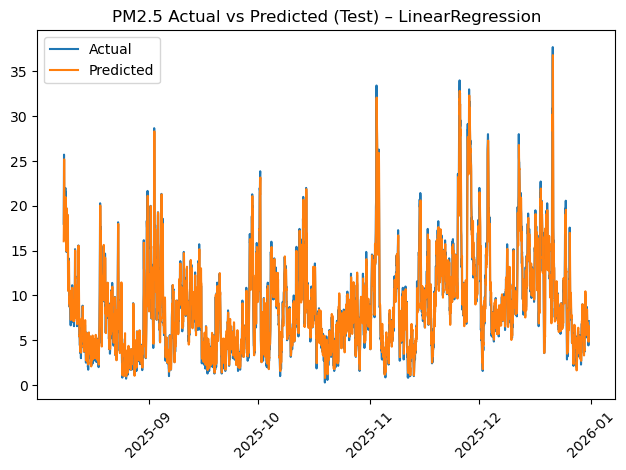

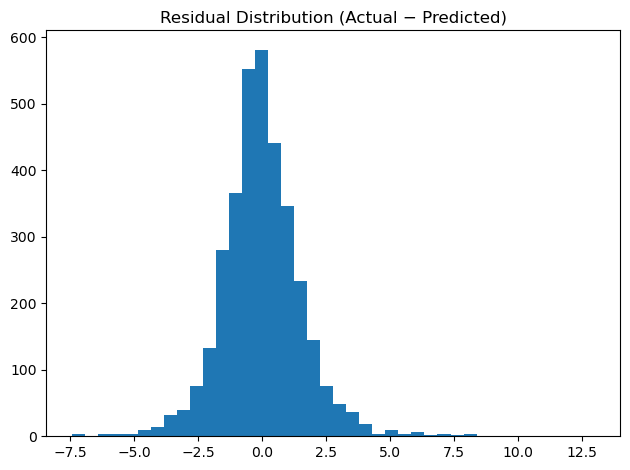

🎉 DONE! Your product is COMPLETE.
- data_clean/cleaned_dataset.csv
- outputs/models/final_model.pkl
- outputs/graphs/*.png
- outputs/metrics.json


In [8]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

# =========================
# SAFETY CHECK
# =========================
if "hourly" not in globals():
    raise NameError("❌ 'hourly' dataframe not found. Run the cell that creates hourly first.")

# =========================
# OUTPUT FOLDERS
# =========================
os.makedirs("data_clean", exist_ok=True)
os.makedirs("outputs/graphs", exist_ok=True)
os.makedirs("outputs/models", exist_ok=True)

# =========================
# SAVE CLEANED DATASET
# =========================
clean_path = "data_clean/cleaned_dataset.csv"
hourly.to_csv(clean_path, index=False)
print("✅ Saved cleaned dataset:", clean_path)

# =========================
# TRAIN / TEST SPLIT (TIME-BASED)
# =========================
feature_cols = [
    "n_sites",
    "hour",
    "dayofweek",
    "month",
    "hour_sin",
    "hour_cos",
    "pm25_lag1",
    "pm25_lag24",
]

X = hourly[feature_cols]
y = hourly["pm25"]
dt = pd.to_datetime(hourly["hour_ts"])

split_idx = int(len(hourly) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dt_test = dt.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# =========================
# MODEL TRAINING + EVALUATION (FIXED RMSE)
# =========================
def evaluate(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))  # ✅ compatible everywhere
    r2 = r2_score(y_test, pred)
    return {
        "name": name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "pred": pred,
        "model": model,
    }

results = []
results.append(evaluate("LinearRegression", LinearRegression()))
results.append(
    evaluate(
        "RandomForest",
        RandomForestRegressor(
            n_estimators=400,
            random_state=42,
            n_jobs=-1,
            min_samples_leaf=2,
        ),
    )
)

for r in results:
    print(f"{r['name']}: MAE={r['mae']:.3f}, RMSE={r['rmse']:.3f}, R2={r['r2']:.3f}")

best = sorted(results, key=lambda x: x["rmse"])[0]
best_name = best["name"]
best_pred = best["pred"]
best_model = best["model"]

# =========================
# SAVE MODEL + METRICS
# =========================
model_path = "outputs/models/final_model.pkl"
joblib.dump(best_model, model_path)
print("✅ Best model:", best_name)
print("✅ Saved model:", model_path)

metrics = {
    "rows_total": int(len(hourly)),
    "rows_train": int(len(X_train)),
    "rows_test": int(len(X_test)),
    "features": feature_cols,
    "results": [
        {k: v for k, v in r.items() if k not in ["pred", "model"]}
        for r in results
    ],
    "best_model": {
        k: v for k, v in best.items() if k not in ["pred", "model"]
    },
}

with open("outputs/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print("✅ Saved metrics: outputs/metrics.json")

# =========================
# GRAPHS
# =========================
plt.figure()
plt.plot(dt_test, y_test.values, label="Actual")
plt.plot(dt_test, best_pred, label="Predicted")
plt.legend()
plt.title(f"PM2.5 Actual vs Predicted (Test) – {best_name}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/graphs/actual_vs_pred.png", dpi=200)
plt.show()

residuals = y_test.values - best_pred
plt.figure()
plt.hist(residuals, bins=40)
plt.title("Residual Distribution (Actual − Predicted)")
plt.tight_layout()
plt.savefig("outputs/graphs/residuals.png", dpi=200)
plt.show()

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    idx = np.argsort(importances)[::-1]

    plt.figure()
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(
        range(len(idx)),
        np.array(feature_cols)[idx],
        rotation=45,
        ha="right",
    )
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.savefig("outputs/graphs/feature_importance.png", dpi=200)
    plt.show()

print("🎉 DONE! Your product is COMPLETE.")
print("- data_clean/cleaned_dataset.csv")
print("- outputs/models/final_model.pkl")
print("- outputs/graphs/*.png")
print("- outputs/metrics.json")


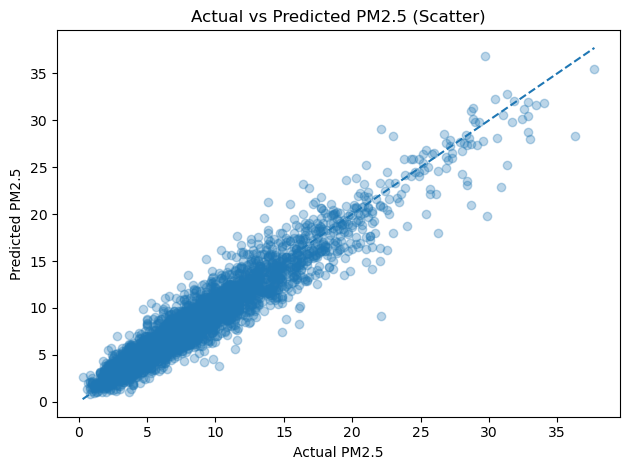

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, best_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5 (Scatter)")
plt.tight_layout()
plt.savefig("outputs/graphs/scatter_actual_vs_pred.png", dpi=200)
plt.show()


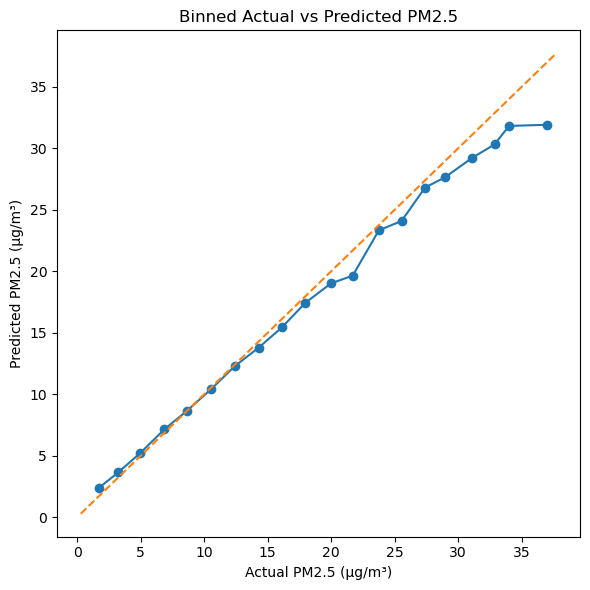

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create dataframe for plotting
df_plot = pd.DataFrame({
    "actual": y_test,
    "predicted": best_pred
})

# Bin actual PM2.5 values
df_plot["bin"] = pd.cut(df_plot["actual"], bins=20)

# Compute mean per bin
binned = df_plot.groupby("bin", observed=False).mean()

# Plot
plt.figure(figsize=(6,6))
plt.plot(binned["actual"], binned["predicted"], marker="o")

# 1:1 reference line
plt.plot(
    [df_plot["actual"].min(), df_plot["actual"].max()],
    [df_plot["actual"].min(), df_plot["actual"].max()],
    linestyle="--"
)

plt.xlabel("Actual PM2.5 (µg/m³)")
plt.ylabel("Predicted PM2.5 (µg/m³)")
plt.title("Binned Actual vs Predicted PM2.5")

plt.tight_layout()
plt.savefig("outputs/graphs/binned_actual_vs_pred.png", dpi=200)
plt.show()
